# ROUGE Scoring Against NIST and Wikipedia

Duplicating CrisisFACTS 2022 assessment via ROUGE

In [85]:
%matplotlib inline

In [86]:
import pandas as pd
import numpy as np
import json
import glob
import gzip

import scipy.stats

import matplotlib.pyplot as plt

In [87]:
import wikipedia

In [88]:
from torchmetrics.text.rouge import ROUGEScore

## Get CrisisFACTS Event Metadata

In [89]:
event_df = pd.read_json("CrisisFACTs-2022to2023.topics.json", lines=False).set_index("eventID")

### Get Summaries from Wikipedia

In [90]:
def get_wiki_summary(url):
    
    if "wikipedia.org" not in url:
        return ""
    
    page_title = url.rpartition("/")[-1]
    print(url)
    page = wikipedia.page(title=page_title, auto_suggest=False)
    
    return page.summary

event_df["wiki.summary"] = event_df["url"].apply(get_wiki_summary)

https://en.wikipedia.org/wiki/Lilac_Fire


https://en.wikipedia.org/wiki/Cranston_Fire
https://en.wikipedia.org/wiki/Holy_Fire_(2018)
https://en.wikipedia.org/wiki/Hurricane_Florence
https://en.wikipedia.org/wiki/2018_Maryland_flood
https://en.wikipedia.org/wiki/Saddleridge_Fire
https://en.wikipedia.org/wiki/Hurricane_Laura
https://en.wikipedia.org/wiki/Hurricane_Sally
https://en.wikipedia.org/wiki/2020_Beirut_explosion
https://en.wikipedia.org/wiki/2020_Houston_explosion
https://en.wikipedia.org/wiki/Edenville_Dam#Dam_failure
https://en.wikipedia.org/wiki/Hurricane_Dorian
https://en.wikipedia.org/wiki/Kincade_Fire
https://en.wikipedia.org/wiki/2020_Easter_tornado_outbreak
https://en.wikipedia.org/wiki/Tornado_outbreak_of_April_22-23,_2020
https://en.wikipedia.org/wiki/Tornado_outbreak_of_March_2-3,_2020


### Get Summaries from Assessors

In [91]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [92]:
event_fact_lists = {}

for req_id,req_data in annotation_data.items():
    event_id = req_id.rpartition("-")[0]
    local_fact_set = {f[0] for f in req_data["fact_list"] if f[2] == "USEFUL_FACT"}
    
    with open("../00-createSummaries/collapsed-event-days/Collapsed-%s.json" % req_id) as in_file:
        local_fact_data = json.load(in_file)
        
    local_fact_text = [
        fact["fact_text"] for fact in local_fact_data 
        if fact["collapsed_fact_id"] in local_fact_set
    ]
    
    local_fact_list = event_fact_lists.get(event_id, [])
    local_fact_list = local_fact_list + local_fact_text
    event_fact_lists[event_id] = local_fact_list

In [93]:
event_df["nist.summary"] = [". ".join(event_fact_lists[event_id]).replace("..", ".") for event_id in event_df.index]


## Save the Summaries

In [94]:
event_df.to_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [95]:
# event_df = pd.read_json("CrisisFACTs-2022to2023.topics.withSummaries_smaller.json", lines=False)

In [96]:
rouge = ROUGEScore(
    use_stemmer=True,
    rouge_keys=("rouge2",)
)

In [97]:
TOP_K = 150

In [98]:
all_req_ids = list(annotation_data.keys())

In [99]:
submission_metrics = {}

for f in glob.glob("submissions/*.gz"):
    
    this_run_id = f.partition("/")[-1].replace(".gz", "")
    print(f, "-->", this_run_id)
    
    this_run_event_request_facts = {k:[] for k in all_req_ids}
    with gzip.open(f, "r") as in_file:
        for line_ in in_file:
            line = line_.decode("utf8")
            
            entry = json.loads(line)
            this_req_id = entry["requestID"]
            
            # We skip days where we have no relevant facts from assessors
            if this_req_id not in all_req_ids:
                continue
            
            this_run_event_request_facts[this_req_id].append(entry)
            
    local_event_summaries = {e_id:[] for e_id in event_df.index}
    for event_request,this_fact_list in this_run_event_request_facts.items():
        event_id = event_request.rpartition("-")[0]
        
        sorted_fact_list = sorted(this_fact_list, key=lambda v: v["importance"], reverse=True)
        this_day_summary = [this_top_fact["factText"] for this_top_fact in sorted_fact_list[:TOP_K]]
        
        local_event_summaries[event_id] = local_event_summaries[event_id] + this_day_summary
        

    wiki_dfs = []
    nist_dfs = []
    for event_id,event in event_df.iterrows():
        
        this_submitted_summary = local_event_summaries[event_id]
        if len(this_submitted_summary) == 0:
            continue

        this_summary_text = ". ".join(this_submitted_summary).replace("..", ".")
        print(event_id, len(this_summary_text))
        
        nist_summary = event["nist.summary"]
        wiki_summary = event["wiki.summary"]

        nist_metric_ = rouge(this_summary_text, nist_summary)
        wiki_metric_ = rouge(this_summary_text, wiki_summary)
        
        nist_metric = {
            "f1": nist_metric_["rouge2_fmeasure"],
            "precision": nist_metric_["rouge2_precision"],
            "recall": nist_metric_["rouge2_recall"],
        }
        
        wiki_metric = {
            "f1": wiki_metric_["rouge2_fmeasure"],
            "precision": wiki_metric_["rouge2_precision"],
            "recall": wiki_metric_["rouge2_recall"],
        }
        
        this_wiki_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in wiki_metric.items()])
        this_nist_df = pd.DataFrame([{"metric":k, "value":v.item(), "event": event_id} for k,v in nist_metric.items()])

        display(this_nist_df)
        
        wiki_dfs.append(this_wiki_df)
        nist_dfs.append(this_nist_df)
        
    full_wiki_df = pd.concat(wiki_dfs)
    full_nist_df = pd.concat(nist_dfs)
    
    submission_metrics[this_run_id] = {
        "wiki": full_wiki_df,
        "nist": full_nist_df,
    }
    
    display(full_nist_df.groupby("metric")["value"].mean())



submissions\Thesis_Retriver.gz --> 
CrisisFACTS-010 22487


,metric,value,event
0,f1,0.309681,CrisisFACTS-010
1,precision,0.297369,CrisisFACTS-010
2,recall,0.323057,CrisisFACTS-010


CrisisFACTS-011 32392


,metric,value,event
0,f1,0.243669,CrisisFACTS-011
1,precision,0.168745,CrisisFACTS-011
2,recall,0.438259,CrisisFACTS-011


CrisisFACTS-012 33304


,metric,value,event
0,f1,0.370907,CrisisFACTS-012
1,precision,0.438652,CrisisFACTS-012
2,recall,0.321287,CrisisFACTS-012


CrisisFACTS-013 37419


,metric,value,event
0,f1,0.377331,CrisisFACTS-013
1,precision,0.475008,CrisisFACTS-013
2,recall,0.312973,CrisisFACTS-013


CrisisFACTS-015 113932


,metric,value,event
0,f1,0.326145,CrisisFACTS-015
1,precision,0.242523,CrisisFACTS-015
2,recall,0.497779,CrisisFACTS-015


CrisisFACTS-016 46513


,metric,value,event
0,f1,0.318256,CrisisFACTS-016
1,precision,0.284884,CrisisFACTS-016
2,recall,0.360483,CrisisFACTS-016


CrisisFACTS-017 36529


,metric,value,event
0,f1,0.394034,CrisisFACTS-017
1,precision,0.487359,CrisisFACTS-017
2,recall,0.330706,CrisisFACTS-017


CrisisFACTS-018 59773


,metric,value,event
0,f1,0.340808,CrisisFACTS-018
1,precision,0.389298,CrisisFACTS-018
2,recall,0.303060,CrisisFACTS-018


metric
f1           0.335104
precision    0.347980
recall       0.360951
Name: value, dtype: float64

In [100]:
all_runs = []
for k,v in submission_metrics.items():
    print(k)
    
    stackable = []
    for comparator,ldf in v.items():
        stackable_ldf = ldf.copy()
        stackable_ldf["target.summary"] = comparator

        stackable.append(stackable_ldf)

    this_run_df = pd.concat(stackable)
    this_run_df["run"] = k
    
    all_runs.append(this_run_df)
    this_run_df.to_csv("evaluation.output.rouge/%s.csv" % k, index=False)
    
all_runs_df = pd.concat(all_runs)
all_runs_df.to_csv("evaluation.output.rouge/all_runs.csv", index=False)

In [101]:
target_summaries = {}
for target in ["wiki", "nist"]:
    this_target_df = all_runs_df[all_runs_df["target.summary"] == target]
    
    index = []
    rows = []
    for run_name,group in this_target_df.groupby("run"):
        print(run_name)
        # this_row = group.pivot("event", "metric", "value").mean()
        this_row = group.pivot(index="event", columns="metric", values="value").mean()
        rows.append(this_row)
        index.append(run_name)

    summary_df = pd.DataFrame(rows, index=index)[[
        "f1", 
    ]]

    final_df = summary_df.sort_values(by="f1", ascending=False)
    final_df.to_csv("evaluation.output.rouge/%s.summary.csv" % target)
    
    target_summaries[target] = final_df

In [102]:
rel2023_events = [
    'CrisisFACTS-009',
    'CrisisFACTS-010',
    'CrisisFACTS-011',
    'CrisisFACTS-012',
    'CrisisFACTS-013',
    'CrisisFACTS-014',
    'CrisisFACTS-015',
    'CrisisFACTS-016',
    'CrisisFACTS-017',
    'CrisisFACTS-018'

]

In [103]:
rows = []
for runtag,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("run"):
    print(runtag)
    t_map = {"run": runtag}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)


	 nist
		 f1 0.33510380797088146
		 precision 0.34797987155616283
		 recall 0.3609505966305733
	 wiki
		 f1 0.0176377488921086
		 precision 0.009120996110141277
		 recall 0.39749795695145923


In [104]:
by_run_df = pd.DataFrame(rows)#.set_index("run")
by_run_df.to_csv("by_run.rouge.summary.csv")
by_run_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
0,0.335104,0.017638


In [105]:
# correlation between wiki and nist
by_run_df[["nist.f1", "wiki.f1"]].corr()

,nist.f1,wiki.f1
nist.f1,NaN,NaN
wiki.f1,NaN,NaN


<Axes: xlabel='nist.f1', ylabel='wiki.f1'>

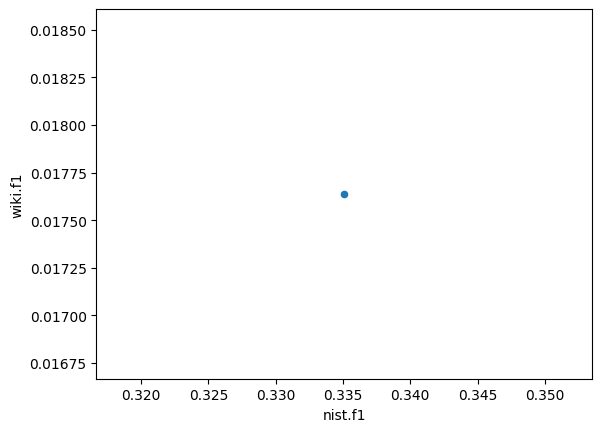

In [106]:
by_run_df[["nist.f1", "wiki.f1"]].plot.scatter(x="nist.f1", y="wiki.f1")

<Axes: >

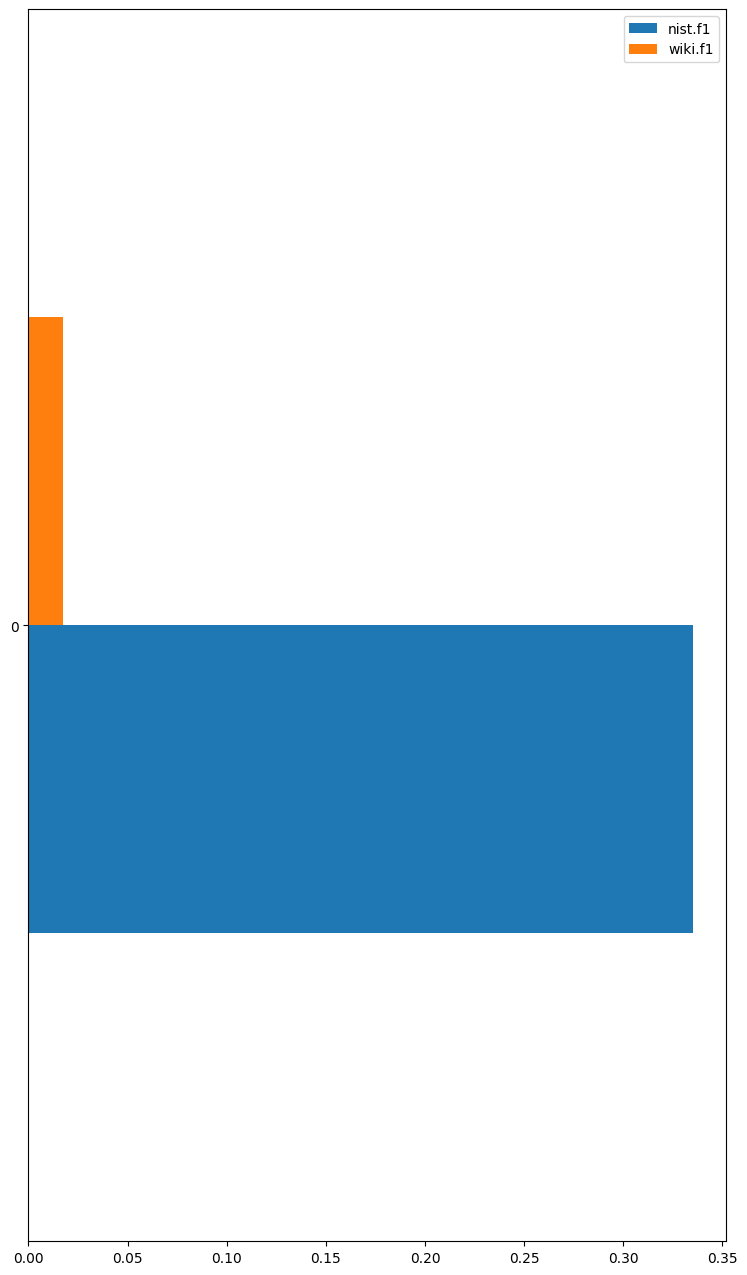

In [107]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_run_df[["nist.f1", "wiki.f1"]].sort_values(by="nist.f1").plot.barh(ax=ax)

In [108]:
by_run_df

,run,nist.f1,nist.precision,nist.recall,wiki.f1,wiki.precision,wiki.recall
0,,0.335104,0.34798,0.360951,0.017638,0.009121,0.397498


## By Day

In [109]:
rows = []
for event,group in all_runs_df[all_runs_df["event"].isin(rel2023_events)].groupby("event"):
    print(event)
    t_map = {"event": event}
    for target,t_group in group.groupby("target.summary"):
        print("\t", target)
        
        if target == "wiki":
            t_group = t_group[~t_group["event"].isin(["CrisisFACTS-011", "CrisisFACTS-012"])]
        for metric,m_group in t_group.groupby("metric"):
            print("\t\t", metric, m_group["value"].mean())
            
            t_map["%s.%s" % (target,metric)] = m_group["value"].mean()
            
    rows.append(t_map)

CrisisFACTS-010
	 nist
		 f1 0.30968138575553894
		 precision 0.29736921191215515
		 recall 0.3230571746826172
	 wiki
		 f1 0.03343549743294716
		 precision 0.017735738307237625
		 recall 0.291262149810791
CrisisFACTS-011
	 nist
		 f1 0.24366910755634308
		 precision 0.16874513030052185
		 recall 0.438259094953537
	 wiki
CrisisFACTS-012
	 nist
		 f1 0.370906800031662
		 precision 0.43865200877189636
		 recall 0.3212873339653015
	 wiki
CrisisFACTS-013
	 nist
		 f1 0.3773306608200073
		 precision 0.47500845789909363
		 recall 0.3129728436470032
	 wiki
		 f1 0.01287128683179617
		 precision 0.006585612893104553
		 recall 0.28260868787765503
CrisisFACTS-015
	 nist
		 f1 0.32614535093307495
		 precision 0.2425234466791153
		 recall 0.49777930974960327
	 wiki
		 f1 0.008588889613747597
		 precision 0.004327803384512663
		 recall 0.5571428537368774
CrisisFACTS-016
	 nist
		 f1 0.31825563311576843
		 precision 0.2848837077617645
		 recall 0.36048343777656555
	 wiki
		 f1 0.020334448665380478
	

In [110]:
by_event_df = pd.DataFrame(rows).set_index("event")
by_event_df.to_csv("by_event.rouge.summary.csv")
by_event_df[["nist.f1", "wiki.f1"]]

,nist.f1,wiki.f1
event,,
CrisisFACTS-010,0.309681,0.033435
CrisisFACTS-011,0.243669,NaN
CrisisFACTS-012,0.370907,NaN
CrisisFACTS-013,0.377331,0.012871
CrisisFACTS-015,0.326145,0.008589
CrisisFACTS-016,0.318256,0.020334
CrisisFACTS-017,0.394034,0.017091
CrisisFACTS-018,0.340808,0.013505


<Axes: ylabel='event'>

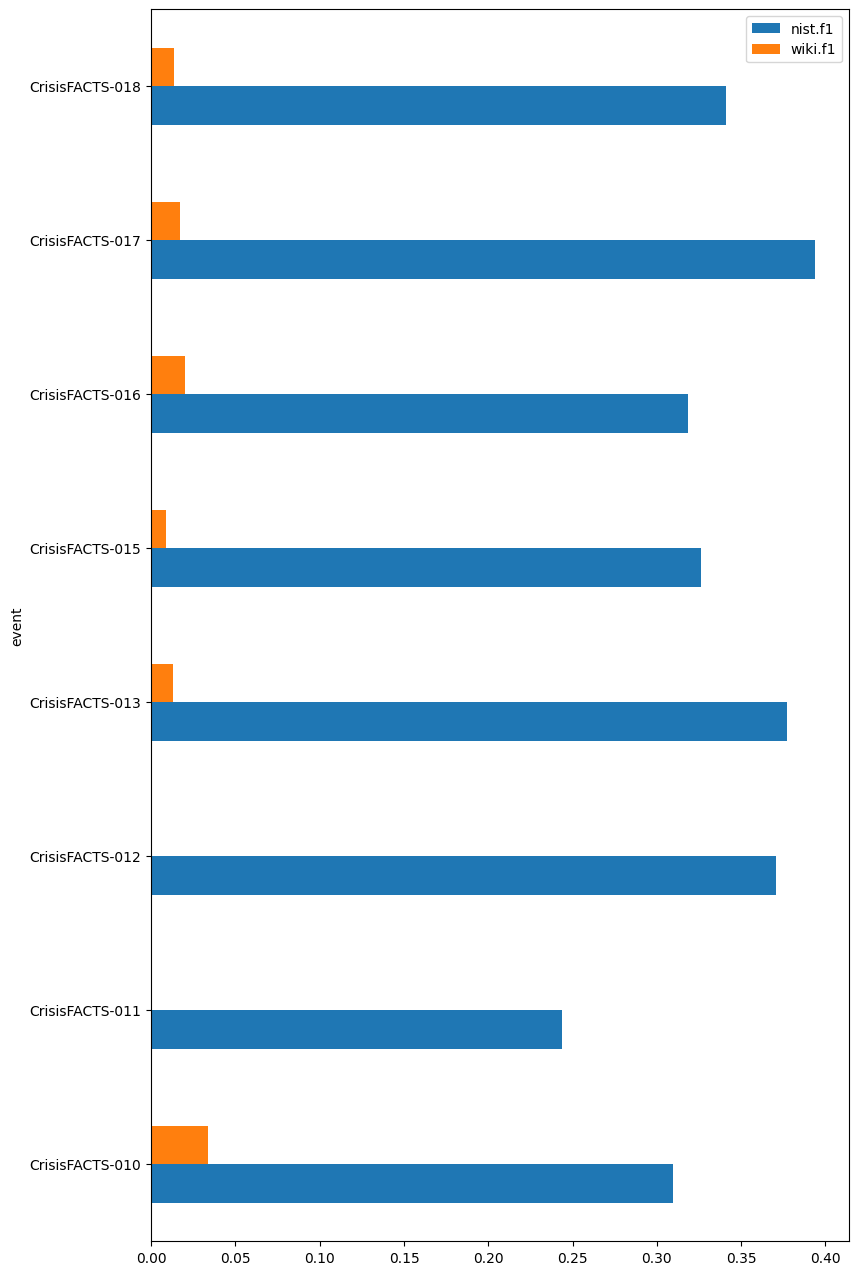

In [111]:
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(1,1,1)

by_event_df[["nist.f1", "wiki.f1"]].plot.barh(ax=ax)

In [112]:
score_df = pd.read_csv("by_event.rouge.summary.csv", index_col=0)
print(score_df.groupby("event").mean().style.to_latex())

\begin{tabular}{lrrrrrr}
 & nist.f1 & nist.precision & nist.recall & wiki.f1 & wiki.precision & wiki.recall \\
event &  &  &  &  &  &  \\
CrisisFACTS-010 & 0.309681 & 0.297369 & 0.323057 & 0.033435 & 0.017736 & 0.291262 \\
CrisisFACTS-011 & 0.243669 & 0.168745 & 0.438259 & nan & nan & nan \\
CrisisFACTS-012 & 0.370907 & 0.438652 & 0.321287 & nan & nan & nan \\
CrisisFACTS-013 & 0.377331 & 0.475008 & 0.312973 & 0.012871 & 0.006586 & 0.282609 \\
CrisisFACTS-015 & 0.326145 & 0.242523 & 0.497779 & 0.008589 & 0.004328 & 0.557143 \\
CrisisFACTS-016 & 0.318256 & 0.284884 & 0.360483 & 0.020334 & 0.010520 & 0.302789 \\
CrisisFACTS-017 & 0.394034 & 0.487359 & 0.330706 & 0.017091 & 0.008712 & 0.447368 \\
CrisisFACTS-018 & 0.340808 & 0.389298 & 0.303060 & 0.013505 & 0.006844 & 0.503817 \\
\end{tabular}

